# Compare similarity search strategies

In this notebook I am comparing the following similarity search strategies for finding genomic regions with similar peaks:

1. kNN search in the autoencoded latent space
2. kNN search in the UMAP 2D embedding of the autoencoded latent space
3. kNN search in the UMAP 2D embedding of the original data space
4. Normalized cross correlation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import os
import sys
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 2400
step_size = window_size / 2
resolution = 100

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'
chroms = ['chr1', 'chr22']

## Load and normalize the data

#### Download the data

In [18]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data... ', end='', flush=True)

# GM12878 DNase-seq read-depth normalized signal
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        bw,
    )

print('done!')

Download data... done!


#### Load models, extract genomic windows, and normalize data

In [20]:
# Load model and data and normalize data

from keras.models import load_model
from server import bigwig

encoder = load_model('../../examples/encode-gm12878-dnase-seq-2011-encoder-2_4kb.h5')
decoder = load_model('../../examples/encode-gm12878-dnase-seq-2011-decoder-2_4kb.h5')

data_train = bigwig.chunk(
    bw,
    window_size,
    resolution,
    step_size,
    [chroms[0]],
    verbose=True,
)

data_test = bigwig.chunk(
    bw,
    window_size,
    resolution,
    step_size,
    [chroms[1]],
    verbose=True,
)

Extracted 207708 windows from chr1 with a max value of 1.0.
Extracted 42753 windows from chr22 with a max value of 1.0.


## Encode data

In [27]:
from keras.metrics import binary_crossentropy
from ae.utils import predict

predicted, _, latent = predict(
    encoder,
    decoder,
    data_test.reshape(data_test.shape[0], data_test.shape[1], 1)
)

## Helper methods

#### Simple kNN search

In [24]:
def kNN(data, source_id, n):
    """K nearest neighbors
    
    Find the `k` nearest neighbors of a 
    """
    dist = np.sqrt(np.sum((data - data[source_id])**2, axis=1))
    return np.argsort(dist)[1:n + 1]

#### Normalized cross correlation search

In [25]:
from scipy.signal import correlate

def norm(data):
    return (data - np.mean(data)) / np.std(data)

def norm2d(data):
    mean = np.mean(data, axis=1).reshape(data.shape[0], 1)
    std = np.std(data, axis=1).reshape(data.shape[0], 1)
    return (data - mean) / std

def best_xcross(data, source, n, normalize=False):
    unknown = data
    template = data[source]
    
    if normalize:
        unknown = norm2d(unknown)
        template = norm(template)
        
    xcross = np.apply_along_axis(lambda m: correlate(m, template, mode='full'), axis=1, arr=unknown)
    xcross[np.where(np.isnan(xcross))] = 0

    max_xcross = np.nanmax(xcross, axis=1)
    best_matches = np.argsort(max_xcross)[::-1]
    
    return best_matches[1:n + 1]

## Generate UMAP embeddings of the latent space and original data space

In [28]:
import umap

embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
).fit_transform(latent)

embedding_original = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
).fit_transform(data_test)

## Plot the UMAP project

The visualization is mostly used to find and pick windows

In [41]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

n = embedding.shape[0]
x = embedding[:, 0]
y = embedding[:, 1]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,reset,save,tap,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)
sizes = [3] * n
colors = ["#3A5785"] * n

sizes[725] = 5
colors[725] = "#E54B2C"

p.scatter(x, y, size=sizes, color=colors, alpha=0.6, name="scatter")

show(p)

Loading BokehJS ...

## Visually compare search strategies

Compare encoding-based knn similarity search strategies against normalize cross correlation.

| Rows  | Description                                      |
|-------|--------------------------------------------------|
| 1     | Search target. Manually picked.                  |
| 2-6   | kNN on the NN-based latent space.                |
| 7-11  | kNN on the UMAP-embedded NN-based latent space.  |
| 12-16 | kNN on the UMAP-embedded original data space.    |
| 17-21 | Normalized cross correlation.                    |

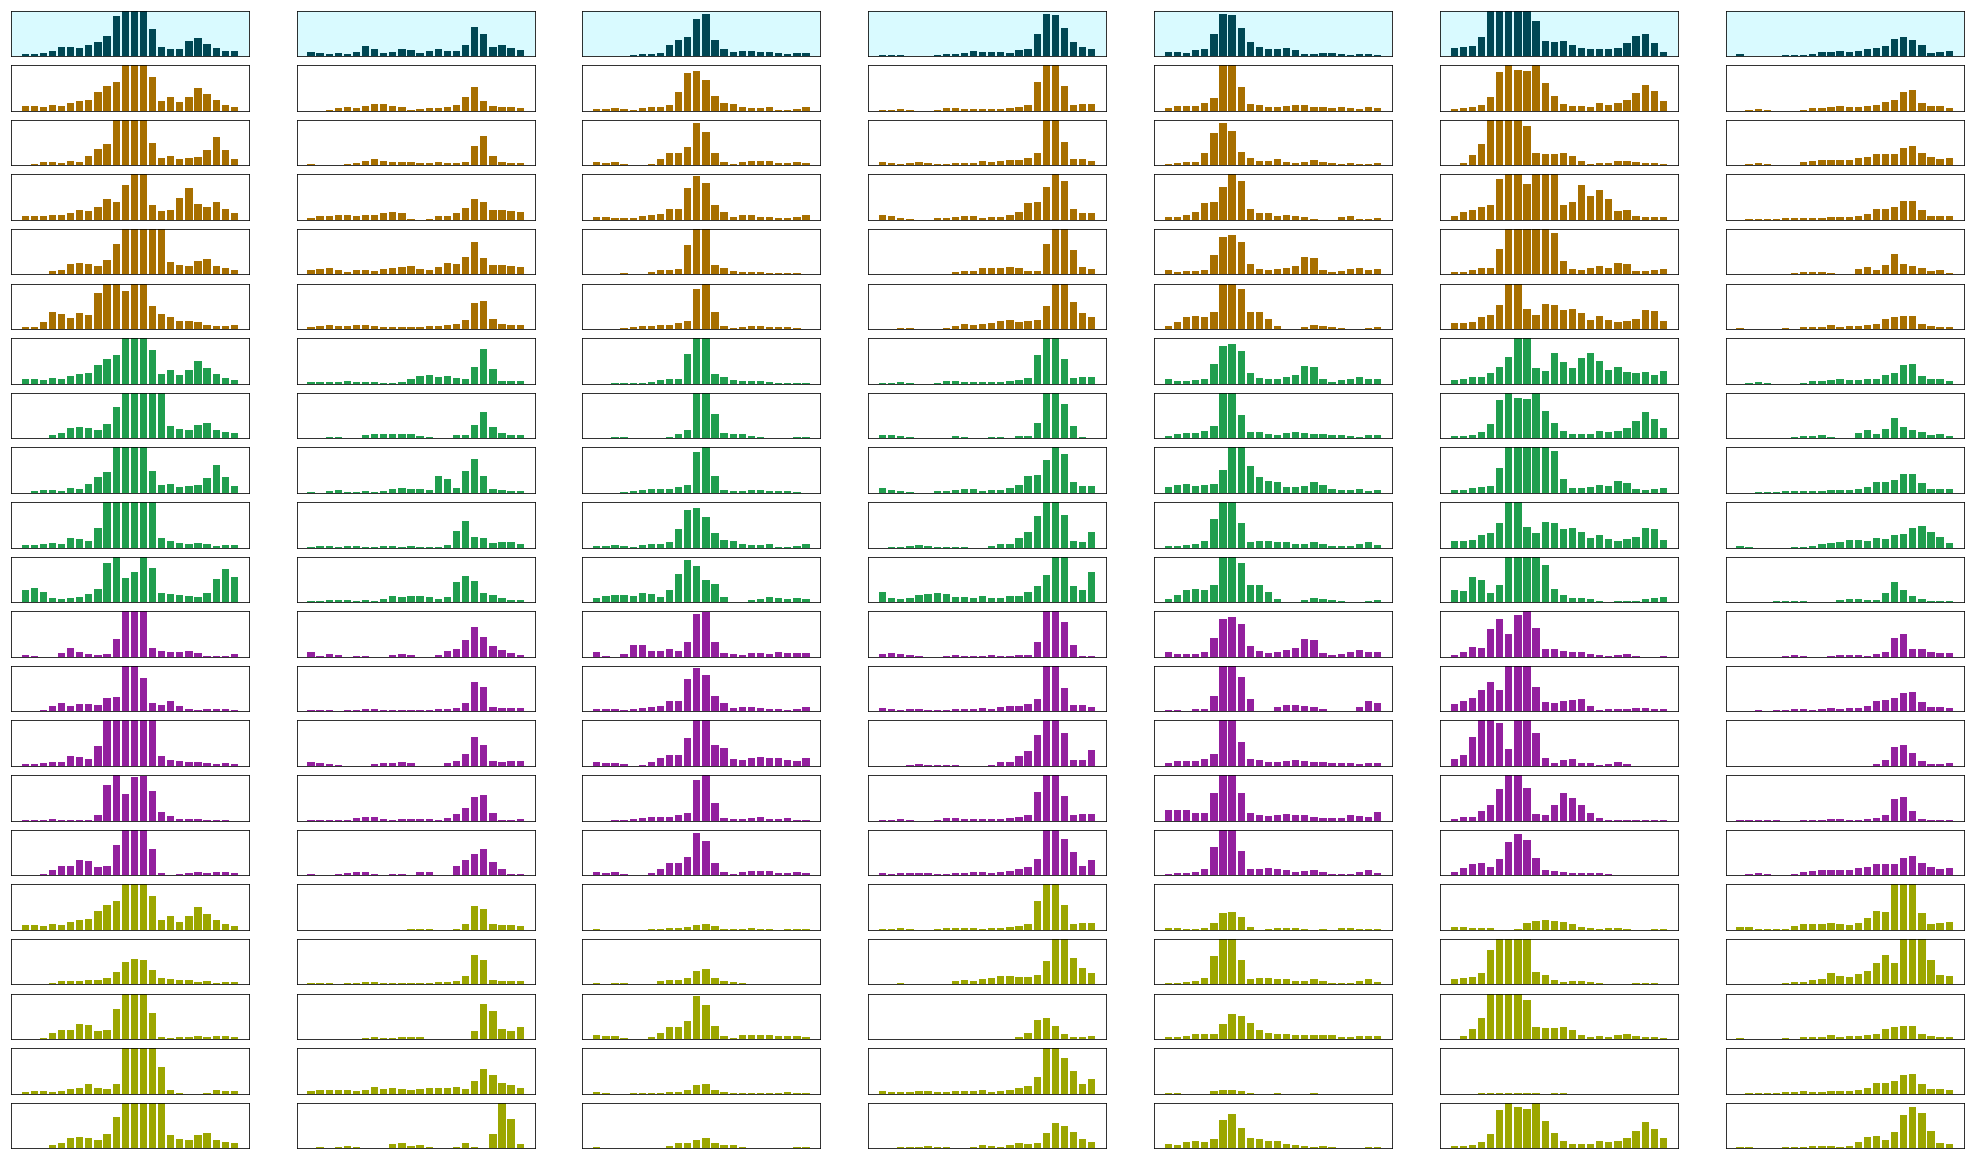

In [52]:
import matplotlib.pyplot as plt 
import numpy as np

n = 5
N = (n + 1) * 6

# Some genomic windows with interesting peaks
sources = [20196, 26570, 26576, 26790, 26791, 31670, 25513]

S = len(sources)
sz = data_test[0].size

plt.figure(figsize=(5 * S, N))

ymax = 1.0

show_predictions = False

for i, source in enumerate(sources):
    ax = plt.subplot(N, S, (i + 1))
        
    ax.set_facecolor("#D9FAFF")
    
    if show_predictions:
        plt.bar(np.arange(sz), data_test[source], color='black', alpha=0.33)
        plt.bar(np.arange(sz), data_test[source], color='black', alpha=0.33)
    else:
        plt.bar(np.arange(sz), data_test[source], color='#004754')

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, target in enumerate(kNN(latent, source, 5)):
        plt.subplot(N, S, ((j + 1) * S) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[target], color='green', alpha=0.33)
            plt.bar(np.arange(sz), data_test[target], color='black', alpha=0.33)
        else:
            plt.bar(np.arange(sz), data_test[target], color='#a76f00')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, target in enumerate(kNN(embedding, source, 5)):
        plt.subplot(N, S, ((j + 6) * S) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[target], color='red', alpha=0.33)
            plt.bar(np.arange(sz), data_test[target], color='black', alpha=0.33)
        else:
            plt.bar(np.arange(sz), data_test[target], color='#209e4e')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, target in enumerate(kNN(embedding_original, source, 5)):
        plt.subplot(N, S, ((j + 11) * S) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[target], color='yellow', alpha=0.33)
            plt.bar(np.arange(sz), data_test[target], color='black')
        else:
            plt.bar(np.arange(sz), data_test[target], color='#93209e')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, target in enumerate(best_xcross(data_test, source, 5, normalize=True)):
        plt.subplot(N, S, ((j + 16) * S) + (i + 1))
        plt.bar(np.arange(sz), data_test[target], color='#9ca600')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

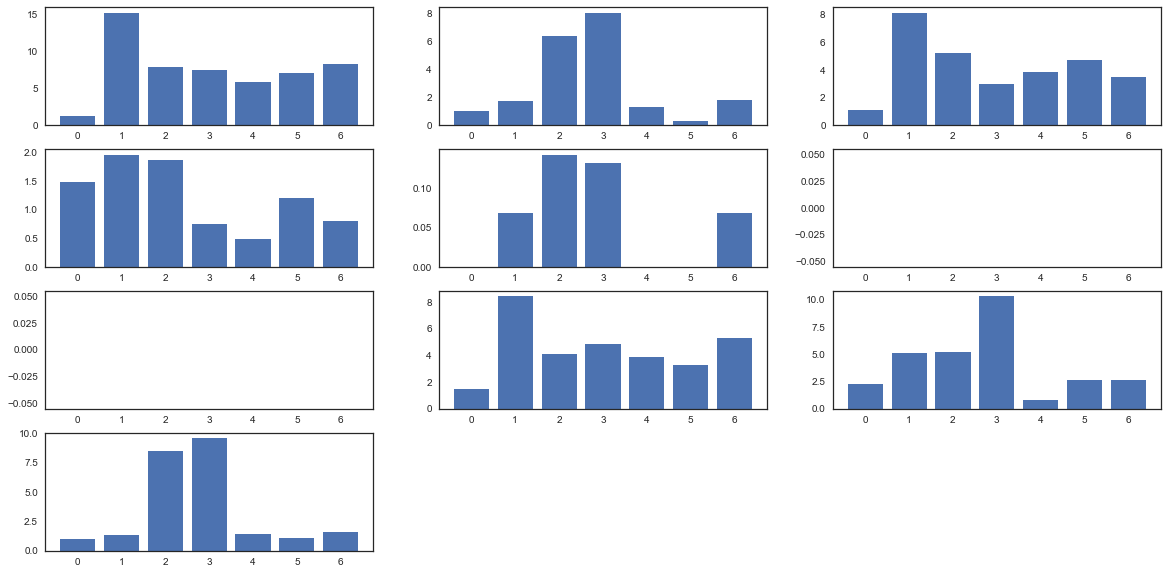

In [209]:
sources = [20196, 26570, 26576, 26790, 31670, 25513]

a = [26570, 25513]
b = [26790, 26791, 26576]

a_nn = [kNN(encoded, a_, 5) for a_ in a]
b_nn = [kNN(encoded, b_, 5) for b_ in b]

dist = np.zeros(())

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(4, 3, i + 1)
    x = [
        np.sqrt(np.sum((encoded[a_nn[0]][:,i] - encoded[a_nn[1]][:,i])**2)),
        np.sqrt(np.sum((encoded[b_nn[0]][:,i] - encoded[b_nn[1]][:,i])**2)),
        np.sqrt(np.sum((encoded[b_nn[0]][:,i] - encoded[b_nn[2]][:,i])**2)),
        np.sqrt(np.sum((encoded[b_nn[1]][:,i] - encoded[b_nn[2]][:,i])**2)),
        np.sqrt(np.sum((encoded[a_nn[0]][:,i] - encoded[b_nn[0]][:,i])**2)),
        np.sqrt(np.sum((encoded[a_nn[1]][:,i] - encoded[b_nn[0]][:,i])**2)),
        np.sqrt(np.sum((encoded[a_nn[1]][:,i] - encoded[b_nn[1]][:,i])**2)),
    ]
    plt.bar(range(len(x)), x)